In [204]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, RemoveMessage
from langchain_aws import ChatBedrock
from langgraph.checkpoint.memory import MemorySaver
import json

In [205]:
def map_to_langchain(messages: list[dict[str, str]]) -> list[BaseMessage]:
    return [
        HumanMessage(m["input"]) if "input" in m.keys() else AIMessage(m["output"])
        for m in messages
    ]

In [206]:
messages_file = "simple_history.json"
messages = json.loads(open(messages_file).read())
messages = map_to_langchain(messages)
messages

[HumanMessage(content="Hi! Imagine you're a quantum physicist. Explain what the point of a Hamiltonian is and how it relates to a Hamiltonian from classical mechanics.", additional_kwargs={}, response_metadata={}),
 AIMessage(content="<think>\nOkay, so I'm trying to understand this question about the Hamiltonian in both quantum physics and classical mechanics, especially since someone asked me if they can explain the difference between a quantum Hamiltonian and a classical one. Hmm, let's start by breaking down each part.\n\nFirst off, what is the Hamiltonian? In classical mechanics, I remember it's that big energy equation you see with all those partial derivatives of position and momentum. It represents the total energy of a system in terms of its positions and momenta. So, the potential plus kinetic energy. Yeah, that makes sense because when something moves, its energy changes based on where it is and how fast it's moving.\n\nNow, quantum mechanics is different. I know there's the 

In [207]:
PROFILE_NAME = "usda"
BEDROCK_MODEL = "us.amazon.nova-lite-v1:0"
llm = ChatBedrock(credentials_profile_name=PROFILE_NAME, model_id=BEDROCK_MODEL)

In [208]:
class APILimitExceededException(Exception):
    """Exception raised when the API request limit is exceeded."""

    def __init__(self, message="API request limit has been exceeded"):
        self.message = message
        super().__init__(self.messaage)

In [ ]:
# Let's frame this as a LangGraph state whose reducer
from typing import Literal


class SummarizerState(MessagesState):
    summary: str


# Should probably be an even number? Or maybe we should ensure that a window starts
# with a human message and ends with an AI message?
SUM_WINDOW = 2
WINDOW_OVERLAP = 0
API_LIMIT = 20  # in event of accidental infinite loop
calls_so_far = 0

# NOTE: not like a STFT if we don't raw-append to the summary
# NOTE: raw-append is cheaper but could result in longer summaries with loss of context between chunks


# TODO: does using RemoveMessage deallocate memory?
def summarize_conversation(state: SummarizerState):
    assert SUM_WINDOW > WINDOW_OVERLAP
    summary = state.get("summary", "")
    if summary:
        # recursive
        summary_prompt = (
            f"This is a play-by-play summary of the conversation so far: {summary}.\n\n",
            "Extend the summary by taking into account the new messages above. "
            "Be sure to return a summary of the whole conversation, not just the "
            "new messages. Use bullet points, being sure to add new bullet points to ",
            "reflect these new messages.",
        )
    else:
        # base
        summary_prompt = (
            "Create a play-by-play summary of the conversation above, explaining what the user "
            "said and what the AI said. Use simple bullet points, and keep the summary "
            "to a few points.",
        )

    # Divide the messages into a window and a tail after the window
    window = state["messages"][:SUM_WINDOW] + [HumanMessage(summary_prompt)]

    # A delta deleting messages from the beginning of the window to the end - WINDOW_OVERLAP
    delete_messages = [
        RemoveMessage(id=m.id)
        for m in state["messages"][: (SUM_WINDOW - WINDOW_OVERLAP)]
    ]

    if calls_so_far < API_LIMIT:
        response = llm.invoke(window)
        calls_so_far += 1
    else:
        raise APILimitExceededException()

    return {"summary": response.content, "messages": delete_messages}


def should_summarize(state: SummarizerState) -> Literal["summarize_conversation", END]:
    """
    Determines whether to continue aggregation or to complete and return the final
    summary.
    """
    return "summarize_conversation" if len(state["messages"]) > 0 else END


workflow = StateGraph(SummarizerState)

# Can this cause infinite recursion? Is a conditional edge to the
workflow.add_node("summarize_conversation", summarize_conversation)
workflow.add_conditional_edges(START, should_summarize)
workflow.add_conditional_edges("summarize_conversation", should_summarize)

In [210]:
start_state = SummarizerState(messages=messages, summary="")
memory = MemorySaver()
summarizer = workflow.compile(checkpointer=memory)

In [211]:
config = {"configurable": {"thread_id": "42"}}

In [212]:
test_human_message = HumanMessage(content="This is a test message.")
print(test_human_message.content)

This is a test message.


In [213]:
TRIM_LEN = 36
for step in summarizer.stream(
    {"messages": messages, "summary": ""}, config=config, stream_mode="values"
):
    summary = step["summary"]
    messages = step["messages"]
    trimmed_messages = [
        m.content[:TRIM_LEN].replace("\n", " ") + "..." for m in messages
    ]
    print(f"Summary: {summary}")
    print(f"Messages remaining:", end=" ")
    print(*trimmed_messages[:TRIM_LEN], sep=" | ")
    print()

Summary: 
Messages remaining: Hi! Imagine you're a quantum physici... | <think> Okay, so I'm trying to under... | Explain what the Hamiltonian for the... | <think> Alright, so I'm trying to un... | What does a ket for this model look ... | <think> Okay, so I'm trying to wrap ... | Why is Paul Dirac such a cool physic... | <think> Alright, so I want to unders... | Thank you for your help! This really... | <think> Okay, so I need to understan... | exit...

Summary: - The user asked for an explanation of the Hamiltonian in both quantum physics and classical mechanics.
- The AI explained the Hamiltonian in classical mechanics as representing the total energy of a system in terms of position and momentum.
- The AI explained the quantum Hamiltonian as an operator acting on a wavefunction to determine possible energy states.
- The AI highlighted the key differences: classical mechanics uses physical variables, while quantum mechanics uses operators and probability amplitudes.
- The AI noted t

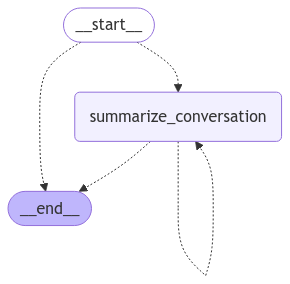

In [214]:
summarizer

Why is the summary totally neglecting the discussion about Paul Dirac?

In [216]:
snap = summarizer.get_state(config=config)
print(snap.values["summary"])

- The user initiated the conversation by asking for an explanation of the Hamiltonian in both quantum physics and classical mechanics.
- The AI provided an explanation of the Hamiltonian in classical mechanics, describing it as a function representing the total energy of a system in terms of position and momentum.
- The AI then explained the Hamiltonian in quantum mechanics, describing it as an operator acting on a wavefunction to determine the possible energy states of a system.
- The AI highlighted the key differences between the classical and quantum Hamiltonians: classical mechanics uses physical variables, while quantum mechanics uses operators and probability amplitudes.
- The AI noted that both frameworks use Hamiltonians to describe system dynamics, but in different forms.
- The user requested a specific explanation of the Hamiltonian for the transverse-field Ising model.
- The AI explained that the transverse-field Ising model's Hamiltonian includes terms for nearest-neighbor 